In [12]:
!pip install -U segmentation-models-pytorch albumentations --user 

  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
  Using cached opencv_python_headless-4.5.5.64-cp37-abi3-macosx_11_0_arm64.whl (29.9 MB)
  Using cached PyYAML-6.0-cp38-cp38-macosx_11_0_arm64.whl
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached scikit_image-0.19.2-cp38-cp38-macosx_12_0_arm64.whl (12.3 MB)
  Using cached scipy-1.8.1-cp38-cp38-macosx_12_0_arm64.whl (28.6 MB)
  Using cached scikit_learn-1.1.1-cp38-cp38-macosx_12_0_arm64.whl (7.6 MB)
  Using cached PyWavelets-1.3.0-cp38-cp38-macosx_11_0_arm64.whl (4.3 MB)
  Using cached networkx-2.8.2-py3-none-any.whl (2.0 MB)
  Using cached imageio-2.19.2-py3-none-any.whl (3.4 MB)
  Using cached tifffile-2022.5.4-py3-none-any.whl (195 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PA

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = '/Users/jinseokhong/data/data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial /Users/jinseokhong/data/data')
    print('Done!')

Loading data...


Cloning into '/Users/jinseokhong/data/data'...


Done!


In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

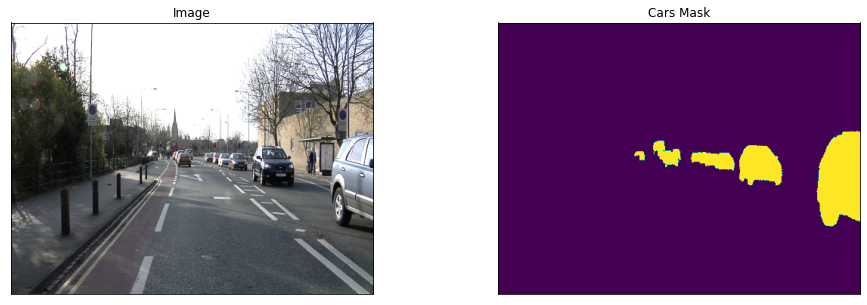

In [10]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

Package                     Version
--------------------------- ------------------
appnope                     0.1.3
argon2-cffi                 21.3.0
argon2-cffi-bindings        21.2.0
asttokens                   2.0.5
attrs                       21.4.0
backcall                    0.2.0
beautifulsoup4              4.11.1
bleach                      5.0.0
certifi                     2022.5.18.1
cffi                        1.15.0
charset-normalizer          2.0.12
cycler                      0.11.0
debugpy                     1.6.0
decorator                   5.1.1
defusedxml                  0.7.1
efficientnet-pytorch        0.6.3
entrypoints                 0.4
executing                   0.8.3
fastjsonschema              2.15.3
flake8                      4.0.1
fonttools                   4.33.3
idna                        3.3
importlib-resources         5.7.1
ipykernel                   6.13.0
ipython                     8.3.0
ipython-genutils            0.2.0
ipywidgets           

In [ ]:
trainingset = ADE20KIndoorDataset(paths["train_file"], seed=10, train=True)

In [ ]:
train_loader = get_loader(trainingset, batch_size=network_info['batch_size'], shuffle=True, num_worker=network_info['num_worker'])

In [ ]:
validationset = ADE20KIndoorDataset(paths['valid_file'], seed=10, train=False)

In [ ]:
valid_loader = get_loader(validationset, batch_size=network_info['batch_size'], shuffle=False, num_worker=network_info['num_worker'])

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=magic_wall_dataset_info['num_classes'],                      # model output channels (number of classes in your dataset)
)

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=devices,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=devices,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, network_info["epochs"]):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')